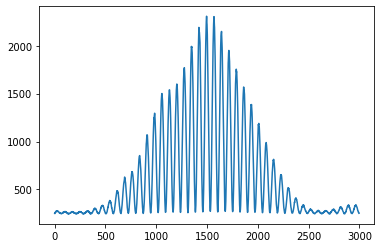

In [3]:
#f = open('/src/psi/raw_data_2013/IDef762186d77f6ad4fd7dcb88b21c76fe_ds_2013format_07_04_2013-06_48.bin')
f = open('/src/psi/raw_data_2013/IDRobot_ds_2013format_04_10_2013-07_14.bin')
import numpy as np
import matplotlib.pyplot as plt
N = 3000

a = np.fromfile(f, dtype=np.uint16)
k = 957
b = a[3000*k+1:3000*(k+1)]
z = 73.35
w = 800
q = 15
i0 = round(w + 8.5*z)
#plt.plot(b[i0-q:i0+q])
i0 = round(w + 1*z)
#plt.plot(b[i0-q:i0+q])
#plt.plot(b)
plt.plot(b[1:3000])

In [1]:
from scipy.io import loadmat
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime
    
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time(dt):
    return (dt - epoch).total_seconds()

class Frame:
    def __init__(self, condition, time, minFrame, minima, maxima):
        self.condition = condition
        self.time = time
        self.minFrame = minFrame
        fv = 0
        N = 9
#        for k in range(0,N):
#            fv += (maxima[k] - minima[k]) / (maxima[k] + minima[k]) 
#        self.fv = fv / N
        self.minima = minima[3:8]
        self.maxima = maxima[3:8]
        self.fv = 0
        
class Session:
    def __init__(self, name, mat, ext):
        #self.name = name
        self.dfvs = []
        conditionValues = mat['conditionValues'].tolist()[0]
        timeValues = mat['timeValues'].tolist()[0]
        self.frames = []
        for k in range(0,len(conditionValues)):
            self.frames.append(Frame(conditionValues[k], timeValues[k], ext[0], ext[19*k+1:19*k+10],ext[19*k+10:19*k+19] ))
        self.conditionTimes = mat['conditionTime'].tolist()[0]
        self.timeOfRecording = datetime.datetime.strptime(mat['timeOfRecording'].tolist()[0], '%d-%b-%Y %H:%M:%S')
        
dirname = 'raw_data_2013'
sessionsR = []
sessionsH = []

for extname in [f for f in listdir(dirname)[0:100] if f.endswith('.ext')]:
    matname = dirname + "/" + extname.replace('.ext','.mat')
    name = extname.replace('.ext','')
    mat = loadmat(matname)
    ext = np.fromfile(dirname + "/" + extname, dtype=np.float32)
    session = Session(name,mat,ext)
    if(matname.find('Robot') != -1):
        sessionsR.append(session)
    else:
        sessionsH.append(session)


In [12]:
def get_absmin(sessions):
    absmin = 2000
    for s in sessions:
        for f in s.frames:
            if(len(f.minima)>0):
                absmin = min(absmin,np.min(f.minima))
    return absmin

def get_visibility(f, absmin):
    k = 2
    absmin = f.minFrame
    return (f.maxima[k] - f.minima[k]) / (f.maxima[k] + f.minima[k] - 2 *absmin) 
    
def analyze(session, lag, absmin):
    if(len(session.conditionTimes) < 3):
        return
    condT0 = session.conditionTimes[0]
    condT1 = session.conditionTimes[1]
    condT2 = session.conditionTimes[2]
    cond2Val = 0
    cond1Val = 0
    cond1N = 0
    cond2N = 0
    condK = 0
    session.dfvs = []
    for k in range(0,len(session.frames)):
        frame = session.frames[k]
        frame.fv = get_visibility(frame, absmin)
        if(frame.time > condT0 + lag):
            if(frame.time > condT2 + lag):
                if(cond1N == 0):
                    break
                dfv = cond1Val/cond1N - cond2Val/cond2N
                session.dfvs.append(dfv)
                cond2Val = frame.fv
                cond1Val = 0
                cond1N = 0
                cond2N = 1
                condK += 2
                if(condK + 2 >= len(session.conditionTimes)):
                    break
                condT0 = session.conditionTimes[condK]
                condT1 = session.conditionTimes[condK+1]
                condT2 = session.conditionTimes[condK+2]
            elif(frame.time > condT1 + lag):
                cond1Val += frame.fv
                cond1N += 1
            else:
                cond2Val += frame.fv
                cond2N += 1

lag = 9

absmin = min(get_absmin(sessionsR), get_absmin(sessionsH))

for s in sessionsR:
    analyze(s, lag, absmin)
    
for s in sessionsH:
    analyze(s, lag, absmin)   

In [14]:
def trim(sessions, tau, outlier):
    dfvs = []
    for s in sessions:
        if(len(s.frames) >= tau):
            dfvs.extend(s.dfvs)
    
    dfvs.sort()
    n = len(dfvs)
    k = round(outlier * n)
    return dfvs[k:n-k]

np.mean(trim(sessionsH,500,0.05))

-4.3466355695404305e-06

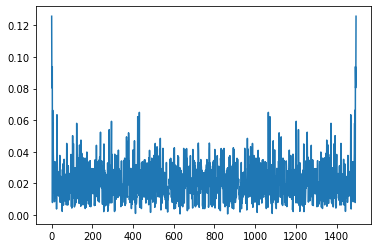

In [66]:
np.abs(np.fft.fft(np.asarray(fvs)[2,:]))
f = np.asarray(fvs)[2,:]
r = .988+.000025*np.cumsum(np.random.randn(1500))+.0006*np.random.randn(1500)
f = r
plt.plot(np.abs(np.fft.fft(f))[2:-1])

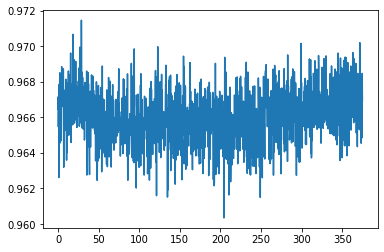

In [21]:
fvs = [list(map(lambda f:f.fv, s.frames[0:1500])) for s in sessionsH if len(s.frames)>2000]
#plt.plot(np.arange(0,0.25*1500,0.25),list(np.mean(fvs,axis=0)))
plt.plot(np.arange(0,0.25*1500,0.25),np.asarray(fvs)[2,:])

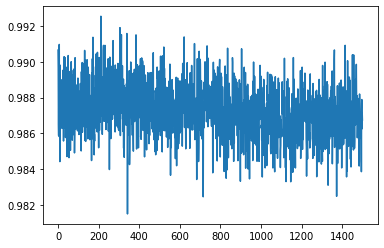

In [30]:
r = .988+.00002*np.cumsum(np.random.randn(1500))+.0015*np.random.randn(1500)
plt.plot(r)

In [1]:
import psi
import numpy as np
s = psi.Sessions('raw_data_2013')


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats

def trimOutliers(dfvs, outlier):
    dfvs.sort()
    n = len(dfvs)
    k = round(outlier * n)
    return dfvs[k:n-k]

lag = 9
outlier = 0.05
absmin = -2
fringe = 0
tau = 1000

s.getTrend()
for offset in range(0,2):
    for fringe in range(1,9):
        s.getVisibilities(fringe, absmin, 1, -offset)
        qstd = []
        for lag in range(0,30):
            dfvs = s.analyzeFringe(lag,tau,outlier)
            r = [[element for tupl in dfvs2 for element in tupl] for dfvs2 in dfvs]
            r[0] = trimOutliers(r[0], outlier)
            r[1] = trimOutliers(r[1], outlier)
            q = np.asarray(r)
            q0 = scipy.stats.ttest_1samp(q[0],0).statistic
            q1 = scipy.stats.ttest_1samp(q[1],0).statistic
            qstd.append([q0,q1])
        qstd = np.asarray(qstd)
        plt.plot(qstd[:,0],'b')
        plt.plot(qstd[:,1],'k')
        


In [1]:
qstd = np.array([[],[]])
qstd=np.append(qstd,[[0,1]])
qstd[:,0]

NameError: name 'np' is not defined

In [27]:
qstd.append([0,1])

AttributeError: 'numpy.ndarray' object has no attribute 'append'